# Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
import keras.losses
from keras.optimizers import SGD
import pickle
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

Using TensorFlow backend.


# Functions

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [3]:
def feature_selection(images,variance_lower_limit):
    selector = VarianceThreshold(variance_lower_limit)
    images_reduced = selector.fit_transform(images)
    print("Images original shape: ",images.shape)
    print("Images reduced shape: ",images_reduced.shape)
    return images_reduced

In [4]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img,grayscale):
    x = img_to_array(img)/255.
    if grayscale==True:
        x = rgb2gray(x)   
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [5]:
 #https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [6]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size,grayscale):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img,grayscale)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
    dataset_np=np.stack(dataset_copy)
    dataset_pd = pd.DataFrame(dataset_np)
    return(dataset_pd)

In [7]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")
    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")    
    return

In [8]:
#function for SVM classifier with parameters of kernel, gamma and C
def Print_Classification_Results(y_dev,y_pred):
    print(classification_report(y_dev, y_pred))
    acc_score = accuracy_score(y_dev, y_pred)
    print("\nAccuracy Score: ","{:.3%}".format(acc_score))
    conf_matrix = confusion_matrix(y_dev, y_pred)
    labels=['0','1','2','3','4']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return acc_score

# Read Data

In [9]:
dataset = pd.read_csv('../Datasets/cartoon_set/labels.csv', sep = '\t', usecols = [2,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (10000, 2)


,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png


In [10]:
images = dataset.iloc[:,1]
labels = dataset.iloc[:,0]

Example of cartoons in Cartoon dataset:

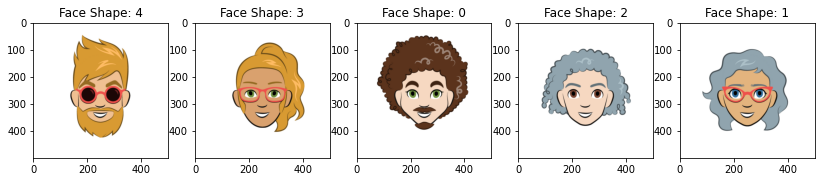

In [11]:
images_folder = '../Datasets/cartoon_set/img/'
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14, 3))

EXAMPLE_PIC = images_folder + '0.png'
ax1.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax1.imshow(img)

EXAMPLE_PIC = images_folder + '2.png'
ax2.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax2.imshow(img)

EXAMPLE_PIC = images_folder + '3.png'
ax3.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax3.imshow(img)

EXAMPLE_PIC = images_folder + '4.png'
ax4.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax4.imshow(img)

EXAMPLE_PIC = images_folder + '8.png'
ax5.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax5.imshow(img)

## Elaborate on multiclass labels

Class=4, n=2000 (20.000%)
Class=3, n=2000 (20.000%)
Class=0, n=2000 (20.000%)
Class=2, n=2000 (20.000%)
Class=1, n=2000 (20.000%)


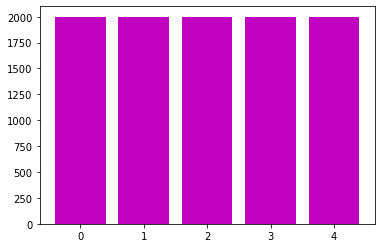

In [12]:
# summarize distribution
counter = Counter(labels)
for k,v in counter.items():
    per = v / len(labels) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values(),color='m')
plt.show()

**Balanced Dataset!!**

## Convert cartoon images dataframe to reshaped flattened array images dataframe

* As long as we are interested in cartoon's face shape, which don't need high resolution (since they are cartoons, not human faces), we reduce image shape from (IMG_HEIGHT,IMG_WIDTH)=(500,500) to 110 each and transform images to gray scale.

* We apply these transformatons from the beginning since we have quite a big dataset with high dimensional features that our computational resources cannot handle in their raw format.

Example of how images will be converted:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)
Step 3 image size: (110, 110, 1)


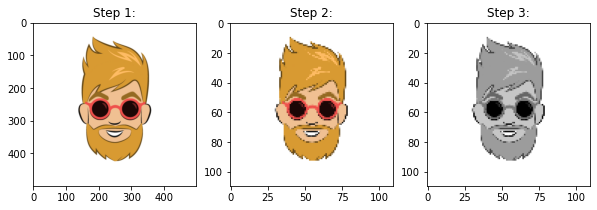

In [13]:
EXAMPLE_PIC = images_folder + '0.png'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (150,150,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

#grey image size = (150,150,1)
arr = img_to_array(img)
gray = rgb2gray(arr)   
ax3.imshow(gray, cmap=plt.get_cmap('gray'))
ax3.set_title("Step 3:")
print("Step 3 image size:",img_to_array(gray).shape)

plt.show()

In [14]:
size=(110,110) 
grayscale=True
reshaped_images=create_flattened_dataset(images,size,grayscale)
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


## Remove features with zero information (white pixels of background)

### Feature Selection:
If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed. 
In this problem, these constant fetures are the white pixels of background.

In [15]:
variance_lower_limit=0
reshaped_images_reduced=feature_selection(reshaped_images,variance_lower_limit)

Images original shape:  (10000, 12100)
Images reduced shape:  (10000, 6725)


## Split reshaped dataset into train, dev, test sets

In [16]:
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images_reduced, labels)

Train Set: (7000, 6725) | Dev Set: (1500, 6725) | Test Set: (1500, 6725)


# Baseline Multiclass Classification

## Linear SVM

Linear SVM implements “one-vs-the-rest” multi-class strategy, thus training n_classes(=5) models.

Total runtime:  64.37937450408936 s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       308
           2       1.00      1.00      1.00       297
           3       1.00      1.00      1.00       282
           4       1.00      1.00      1.00       328

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  100.000%


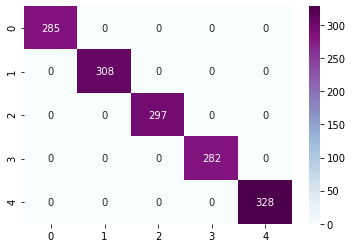

In [17]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train, y_train)
y_pred = clf_svm_linear.predict(X_dev)
runtime_Linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_Linear_SVM,"s")
accuracy = Print_Classification_Results(y_dev,y_pred)

Evaluate the previous model on test data:

Total runtime:  73.77546715736389 s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       319
           2       1.00      1.00      1.00       307
           3       1.00      1.00      1.00       295
           4       1.00      1.00      1.00       272

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  100.000%


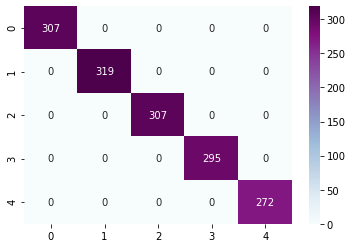

In [18]:
y_pred = clf_svm_linear.predict(X_test)
runtime_Linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_Linear_SVM,"s")
accuracy = Print_Classification_Results(y_test,y_pred)

**By running just a simple linear classification estimator, it is obvious that our data are perfectly linearly separable so we get 100% accuracy in classifying data.**

### Why SVM?

Paper: https://arxiv.org/ftp/arxiv/papers/0709/0709.3967.pdf

Support Vector Machines (SVMs) have their roots in Statistical Learning Theory (Vapnik, 1995).They have been widely applied to machine vision fields such as character, handwriting digit and text recognition (Vapnik, 1995; Joachims, 1998), and more recently to satellite image classification (Huang et al, 2002; Mahesh and Mather, 2003). SVMs, like Artificial Neural Networks and other nonparametric classifiers have a reputation for being robust (Foody and Mathur, 2004a; Foody and Mathur, 2004b).

SVM is an exciting algorithm and the concepts are relatively simple. The classifier separates data points using a hyperplane with the largest amount of margin. That's why an SVM classifier is also known as a discriminative classifier. SVM finds an optimal hyperplane which helps in classifying new data points.

In order to absorb the resulting high dimensionality of the input space, support vector machines (SVMs), which are known to work well even in high-dimensional space, are used as the face recognizer.

# Visualising high-dimensional Cartoon dataset using PCA and t-SNE

## PCA

inspired by: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

What we can do is reduce the number of dimensions drastically whilst trying to retain as much of the ‘variation’ in the information as possible. This is where we get to dimensionality reduction and specifically the technique of Principal Component Analysis (PCA).  It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed. 

First we gonna concat features (pixels) dataframe and labels matrix to a Dataframe:

In [19]:
feat_cols = [ 'pixel'+str(i) for i in range(reshaped_images_reduced.shape[1])]
df_cartoons = pd.DataFrame(reshaped_images_reduced,columns=feat_cols)
df_cartoons['label'] = labels.to_numpy()
df_cartoons.shape

(10000, 6726)

[0.91050872 0.90860232 0.90663422 0.90456482 0.90245734 0.90031337
 0.89806366 0.89578349 0.89343642]


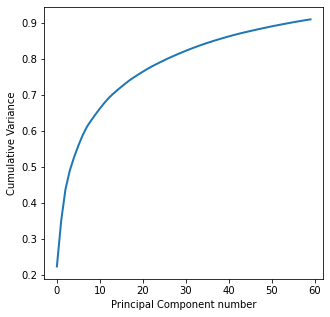

In [20]:
n = 60
pca = PCA(n_components=n)
df_PCA = pca.fit_transform(df_cartoons.iloc[:,:-1])

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar[:-10:-1])
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

**From this plot we can see that over 90% of information is provided only by 60 variables (or eigenvectors)!!** 

In [21]:
pca = PCA(n_components=60)
df_PCA = pca.fit_transform(df_cartoons.iloc[:,:-1])

df_cartoons['pca 1'] = df_PCA[:,0]
df_cartoons['pca 2'] = df_PCA[:,1]
df_cartoons['pca 3'] = df_PCA[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.22375462 0.12700827 0.08750531 0.05191869 0.03721579 0.03215394
 0.02904251 0.02350597 0.01796028 0.01662804 0.01596684 0.01486949
 0.01365307 0.01155225 0.01047879 0.00990062 0.00969215 0.00916754
 0.00799111 0.00771195 0.00742222 0.00716625 0.00682324 0.00610706
 0.0059629  0.00582711 0.00577037 0.00524594 0.00523284 0.00503814
 0.00496343 0.00465954 0.00453615 0.00440576 0.00427134 0.00398101
 0.00381033 0.00378505 0.00360141 0.00347845 0.00335036 0.00327708
 0.0031563  0.00295038 0.00279693 0.0027743  0.00276441 0.00262102
 0.00257607 0.00255011 0.00249653 0.00235498 0.00234706 0.00228035
 0.00225057 0.00214521 0.00209671 0.00206543 0.00197042 0.00190461]


Now, given that the first two components account for about 35% of the variation in the entire dataset lets see if that is enough to visually set the different face shapes. What we can do is create a scatterplot of the first and second principal component and color each of the different types of faces with a different color. If we are lucky the same type of faces will be positioned (i.e., clustered) together in groups, which would mean that the first two principal components actually tell us a great deal about the specific types of faces.

In [22]:
df_cartoons_s = shuffle(df_cartoons)
df_cartoons_s.shape

(10000, 6729)

<AxesSubplot:xlabel='pca 1', ylabel='pca 2'>

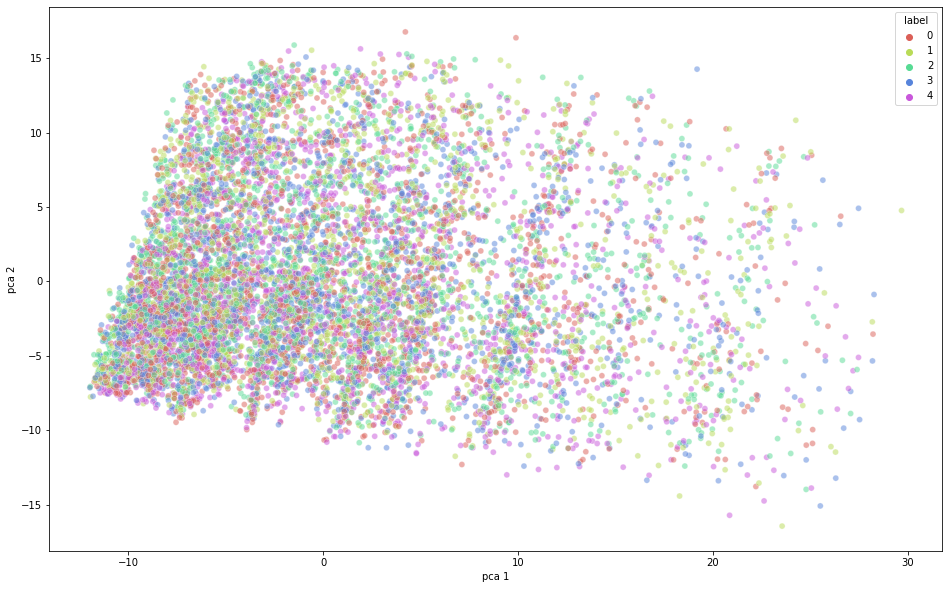

In [23]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca 1", y="pca 2",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df_cartoons_s,
    legend="full",
    alpha=0.5
)

From the graph we can see the two components clearly are not enough to set all of them apart. Luckily there is another technique that we can use to reduce the number of dimensions that may prove more helpful. The method we will be exploring is known as t-SNE (t-Distributed Stochastic Neighbouring Entities).

For a 3d-version of the same plot:

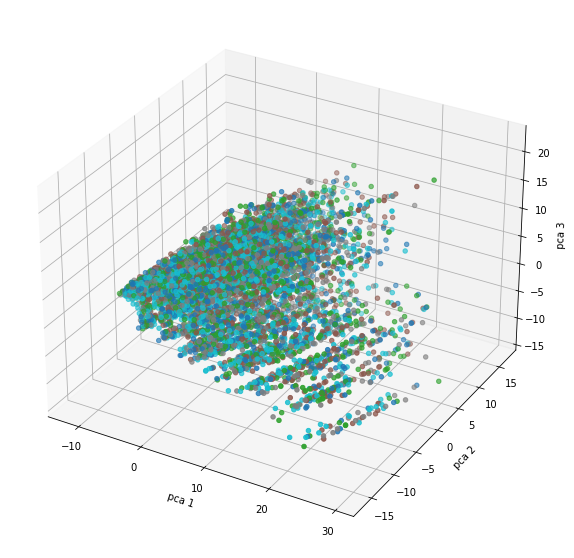

In [24]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_cartoons_s["pca 1"], 
    ys=df_cartoons_s["pca 2"], 
    zs=df_cartoons_s["pca 3"], 
    c=df_cartoons_s["label"], 
    cmap='tab10'
)
ax.set_xlabel('pca 1')
ax.set_ylabel('pca 2')
ax.set_zlabel('pca 3')
plt.show()


## t-SNE

Paper:https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.

Essentially what this means is that it looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions. The way it does this is computationally quite heavy and therefore there are some (serious) limitations to the use of this technique. For example one of the recommendations is that, in case of very high dimensional data, you may need to apply another dimensionality reduction technique before using t-SNE: *It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.*

In [25]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=800)
tsne_results = tsne.fit_transform(df_cartoons_s)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 22.225s...
[t-SNE] Computed neighbors for 10000 samples in 896.873s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.671031
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.710617
[t-SNE] KL divergence after 800 iterations: 1.326177
t-SNE done! Time elaps

Now that we have the two resulting dimensions we can again visualise them by creating a scatter plot of the two dimensions and coloring each sample by its respective label.

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

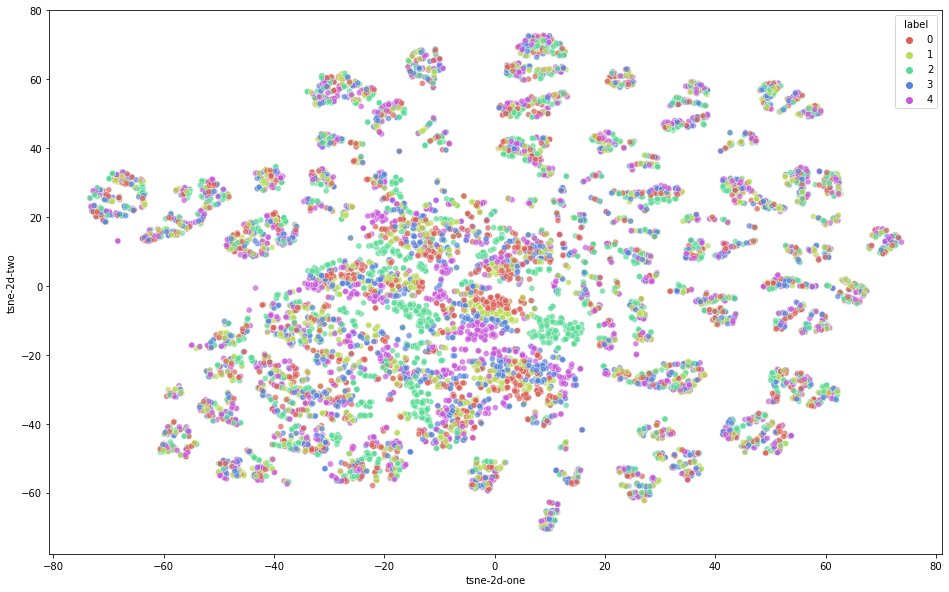

In [26]:
df_cartoons_s['tsne-2d-one'] = tsne_results[:,0]
df_cartoons_s['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df_cartoons_s,
    legend="full",
    alpha=0.7
)


**However, we can see that the face shapes are NOT clearly clustered in their own sub groups, so we have to make some assumptions about our sample.**

# Final Assumptions

Taking into account the perfectly separable unseen dev and test samples into face shape classes we can make the following assumptions about our total dataset:
* Our training and test/dev data are too much alike compared to practical scenarios. This is quite possible, since cartoons are created by a finite variety of characteristics that are replicated just though different combinations.
* Data from the train set have leaked into the test one, which means the whole dataset consists of duplicates (at least), so the estimator knows the labels of incoming data of test/dev sets.
* the custom cartoon dataset comprises high quality and clear images of cartoons which maybe have gone through deliberate statistics before given to us.Hence when we deploy our model to another unpreproccessed test set it may not perform as well because the images the model would be using may not be as clear as the training and test data. 100% test accuracy isn't bad but not a final performance metric...